In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
%matplotlib inline


In [3]:
import time
import numpy as np
import tensorflow as tf



In [4]:
from imageai.Detection.Custom import CustomObjectDetection

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()

In [5]:
from src.data import get_image_value
from src.data import get_file_list
from src.data import extract_roi
from src.utils import show_result_img

In [6]:
max_idx = 45
sample_file_list = [f'./data/images/samples/s{i}.jpg' for i in range(0,max_idx)]
input_img = []
for i in range(0,max_idx):
    input_img.append(cv2.imread(sample_file_list[i]))

In [17]:
detect_model_folder = f"./data/images/box/models/"
class_model_folder = f"./data/models/mobilnet/"
ignore_file = '.ipynb_checkpoints'
json_path = './data/images/box/json/detection_config.json'

In [8]:
true_dic ={
    0:['true', 'true'],
    1:['true', 'true'],
    2:['true', 'true'],
    3:['true', 'true'],
    4:['false', 'false'],
    5:['true', 'true', 'true', 'true'],
    6:['false', 'false'],
    7:['false'],
    8:['false', 'false'],
    9:['false', 'true', 'true'],
    10:['true', 'true'],
    11:['true', 'true'],
    12:['true', 'true'],
    13:['false', 'true'],
    14:['false', 'true'],
    15:['true', 'true'],
    16:['false', 'false'],
    17:['true', 'false'],
    18:['false', 'true'],
    19:['true', 'true'],
    20:['true', 'true'],
    21:['true', 'true'],
    22:['true', 'true'],
    23:['true', 'true'],
    24:['false', 'true'],
    25:['true', 'true'],
    26:['true', 'true'],
    27:['true', 'false'],
    28:['false', 'false'],
    29:['true', 'true'],
    30:['true', 'false'],
    31:['true', 'false', 'false'],
    32:['false', 'true'],
    33:['false', 'true'],
    34:['false', 'false'],
    35:['false', 'false'],
    36:['false', 'false'],
    37:['false', 'false'],
    38:['false', 'true', 'true'],
    39:['true', 'false'],
    40:['true', 'false'],
    41:['false', 'true'],
    42:['false', 'false'],
    43:['false', 'false'],
    44:['false', 'false'],
}

In [9]:

def model_load(detection_model_path,
               json_path,
               cls_model_path,):
    
    detector = CustomObjectDetection()
    detector.setModelTypeAsYOLOv3()
    
    detector.setModelPath(detector_model_path) 
    detector.setJsonPath(json_path)
    detector.loadModel()
    
    model = tf.keras.models.load_model(cls_model_path)
    
    return detector, model


def detect_misprinted_label(img,
                            detector, 
                            model,
                            img_show = True):
    
    img = img.copy()
    start_tm = time.time()
    _, detections = detector.detectObjectsFromImage(input_image=img,
                                                   input_type='array',
                                                   output_type='array')
                                                 
    
    #print ("Detection time : {:.2f}s".format(time.time() - start_tm))
    
    results = []
    if len(detections)>0:
        roi_list = extract_roi(img, detections)
        
        pred = model.predict(np.array(roi_list))
        
        out_img, results = show_result_img(img, pred, detections, img_show=img_show)
    else:
        out_img = img
        
    return out_img, results
    

In [11]:
detect_model_list = os.listdir(detect_model_folder)
if ignore_file in detect_model_list:
    idx = detect_model_list.index(ignore_file)
    detect_model_list.pop(idx)

In [12]:
cls_model_list = os.listdir(class_model_folder)
if ignore_file in cls_model_list:
    idx = cls_model_list.index(ignore_file)
    cls_model_list.pop(idx)

In [13]:
def return_acc(true, pred):
    
    obj_list = []
    acc_list = []
    dec_list = []
    for idx, item in enumerate(pred):
        pred_obj = item
        true_obj = true[idx]
        obj_list.append(len(true_obj))
        dec_list.append(len(pred_obj))
        for i, t in enumerate(true_obj):
            if i < len(pred_obj):
                if t == pred_obj[i]:
                    acc_list.append(1)
                else:
                    acc_list.append(0)
            else:
                acc_list.append(0)
    
    print (f"Acc : {np.mean(acc_list)*100:.2f}%, Detected obj : {np.sum(dec_list)}")
    return acc_list, dec_list, obj_list 
#_, _, _ = return_acc(true_dic, result_class)

In [14]:


def run(detector_model_path, json_path, cls_model_path, img_show = True):
    detector, model = model_load(detector_model_path,
                             json_path,
                             cls_model_path)
    
    result_img = []
    result_class = []

    for i in range(len(input_img)):
        out_img, out_cls = detect_misprinted_label(input_img[i], detector, model, img_show = False)
        result_img.append(out_img)
        result_class.append(out_cls)
        
    print (detector_model_path)
    print (cls_model_path)
    if img_show : 
        max_row = 9
        max_col = 5
        fig, ax = plt.subplots(max_row, max_col, figsize=(20,20), dpi=80)
        for i in range(max_row*max_col):
            rw = i%max_row
            cl = i%max_col
            #print (i, rw, cl)
            ax[rw, cl].imshow(result_img[i])
    
    _, _, _ = return_acc(true_dic, result_class)
    
    return result_class

In [18]:
detector_model_path = f"./data/images/box/models/detection_model-ex-023--loss-0016.736.h5"
for cls_file in cls_model_list:
    result_class = run(detector_model_path, json_path, os.path.join(class_model_folder,cls_file), False)

/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
/opt/conda/lib/python3.7/site-packages/imageai/Detection/Custom/__init__.py:1248: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.10374.h5
Acc : 61.70%, Detected obj : 66
./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.09676.h5
Acc : 58.51%, Detected obj : 66
./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.1453.h5
Acc : 57.45%, Detected obj : 66
./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.11545.h5
Acc : 60.64%, Detected obj : 66
./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_2.h5
Acc : 56.38%, Detected obj : 66
./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66


In [20]:

for dtc_file in detect_model_list:
    result_class = run(os.path.join(detect_model_folder, dtc_file), json_path, './data/models/mobilnet/mobilenet_val_loss_0.0756.h5', False)

./data/images/box/models/detection_model-ex-052--loss-0010.760.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66
./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66
./data/images/box/models/detection_model-ex-032--loss-0014.714.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66
./data/images/box/models/detection_model-ex-030--loss-0010.144.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66
./data/images/box/models/detection_model-ex-033--loss-0010.930.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66
./data/images/box/models/detection_model-ex-023--loss-0016.847.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66
./data/images/box/models/detection_model-ex-011--loss-0017.061.h5
./data/models/mobilnet/mobilenet_v

./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.0756.h5
Acc : 61.70%, Detected obj : 66


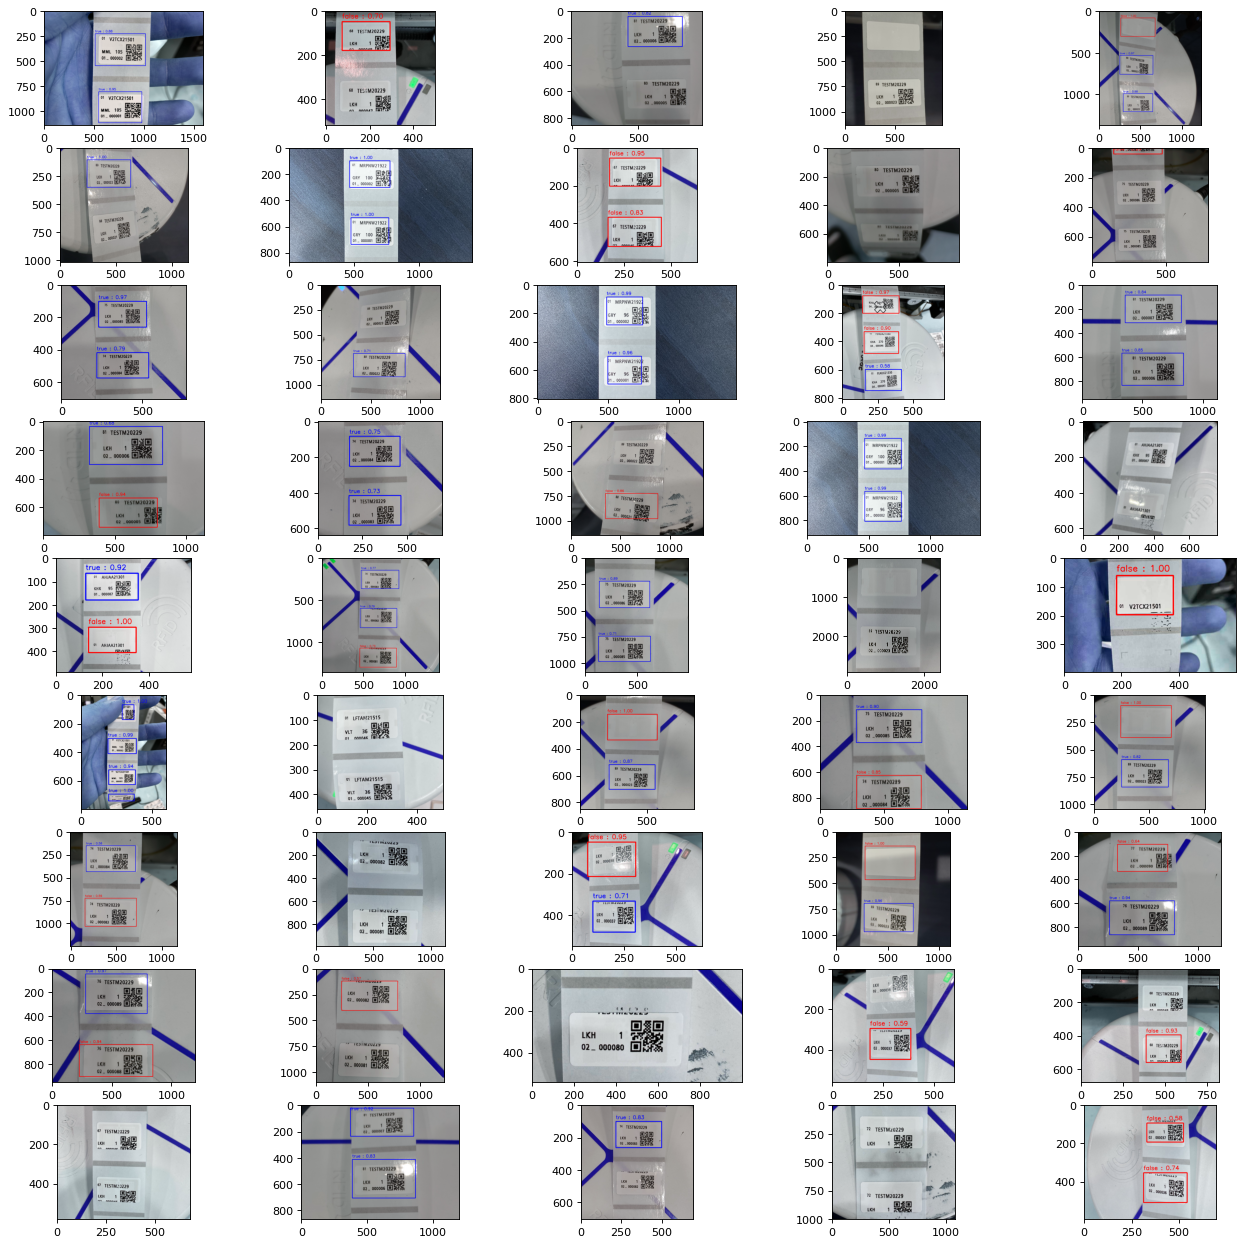

In [42]:
detector_model_path = f"./data/images/box/models/detection_model-ex-023--loss-0016.736.h5"
cls_model_path = f"./data/models/mobilnet/mobilenet_val_loss_0.0756.h5"
result_class = run(detector_model_path, json_path, cls_model_path)

./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.1453.h5
Acc : 57.45%, Detected obj : 66


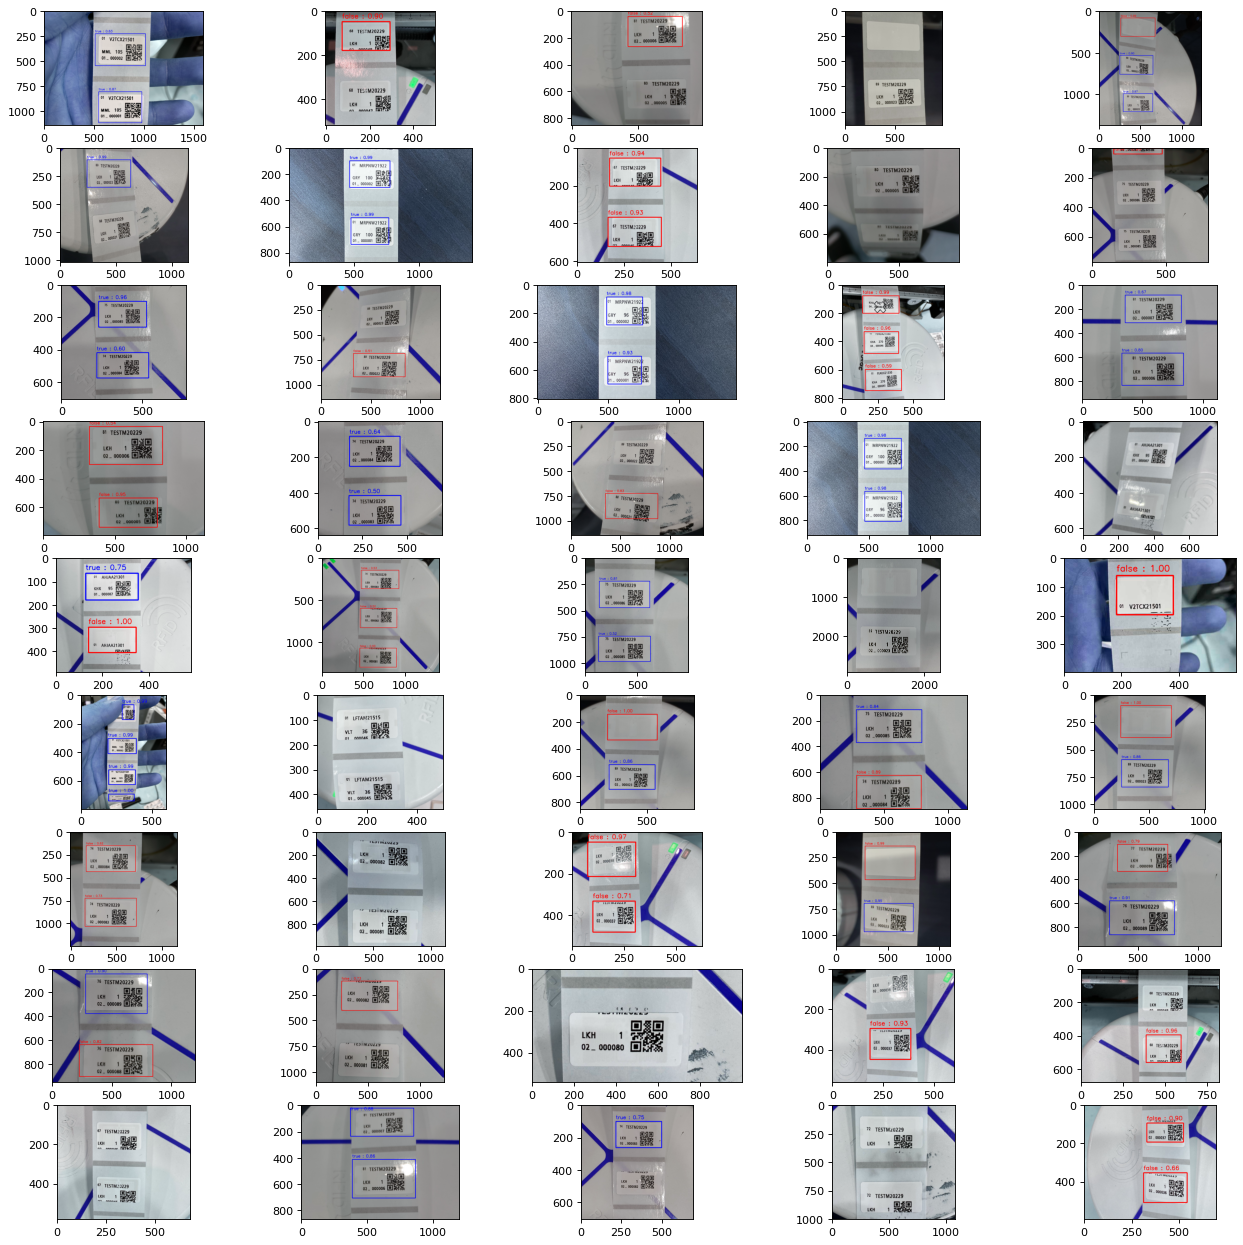

In [43]:
detector_model_path = f"./data/images/box/models/detection_model-ex-023--loss-0016.736.h5"
cls_model_path = f"./data/models/mobilnet/mobilenet_val_loss_0.1453.h5"
result_class = run(detector_model_path, json_path, cls_model_path)

./data/images/box/models/detection_model-ex-023--loss-0016.736.h5
./data/models/mobilnet/mobilenet_val_loss_0.11545.h5
Acc : 60.64%, Detected obj : 66


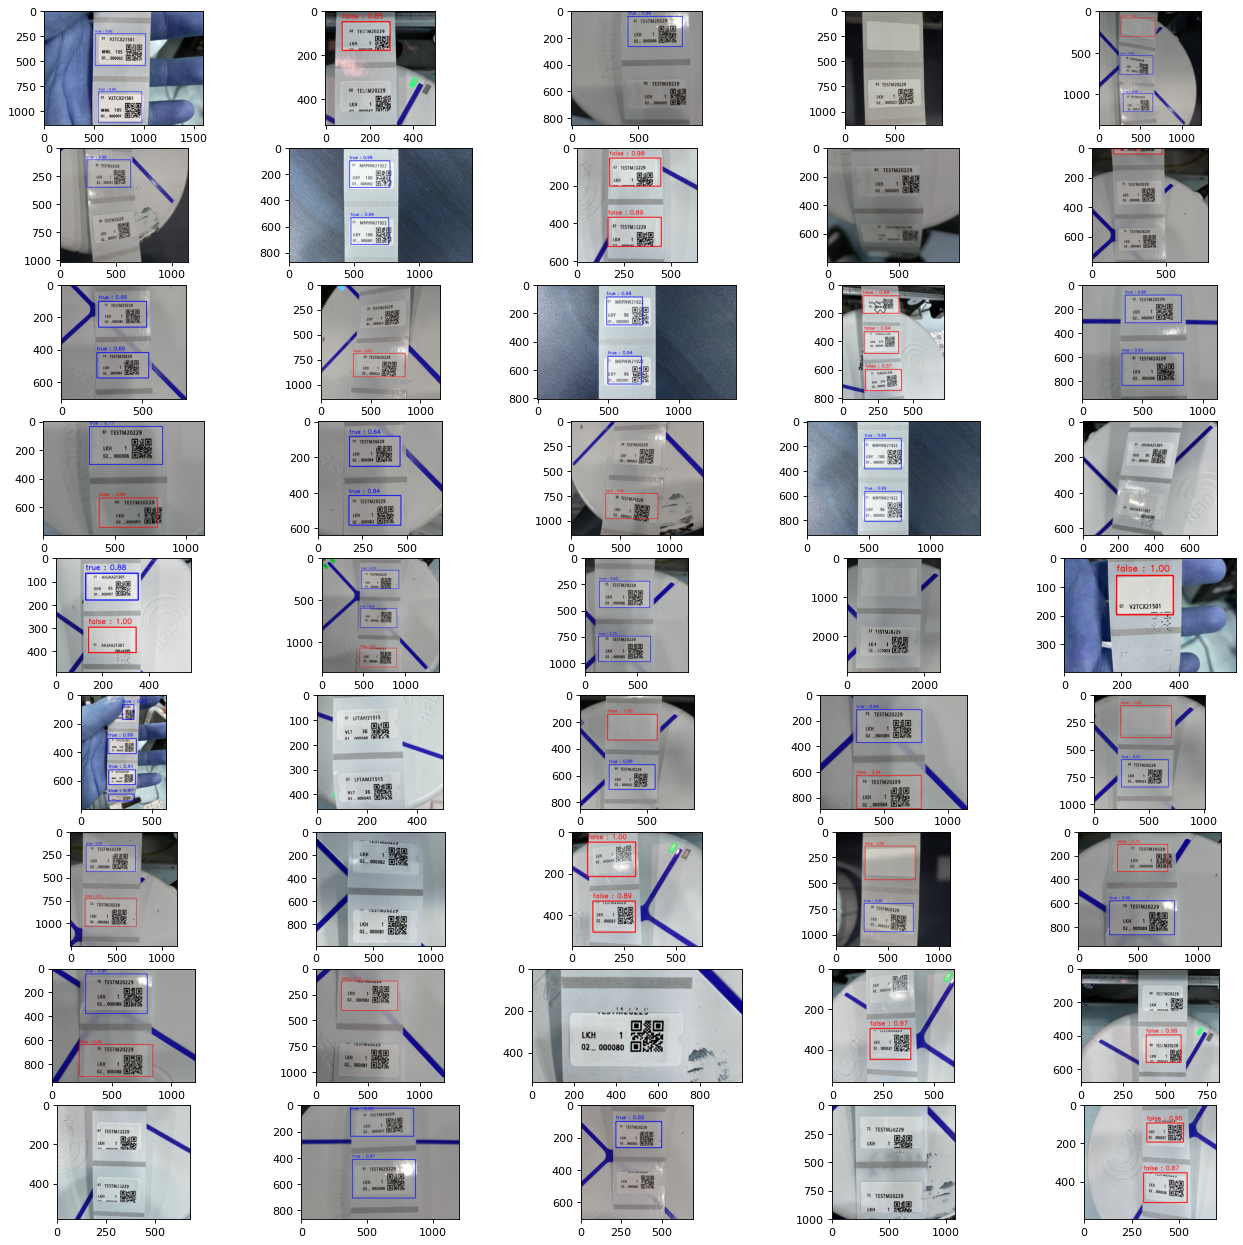

In [44]:
detector_model_path = f"./data/images/box/models/detection_model-ex-023--loss-0016.736.h5"
cls_model_path = f"./data/models/mobilnet/mobilenet_val_loss_0.11545.h5"
result_class = run(detector_model_path, json_path, cls_model_path)